# **Finding Advanced Lane Lines on the Road** 


In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

In [2]:
import math

last_frame_left = None
last_frame_right = None
last_frame_weight = 0.9

def calibrate_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #cv2.drawChessboardCorners(img, (8,6), corners, ret)
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            #plt.figure()
            #plt.imshow(img)
            
    return objpoints, imgpoints

def undistort_image(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #plt.figure(); plt.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    return undist

def color_threshold(img):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # Plotting thresholded images
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    #ax1.set_title('Stacked thresholds')
    #ax1.imshow(color_binary)
    #ax2.set_title('Combined S channel and gradient thresholds')
    #ax2.imshow(combined_binary, cmap='gray')
    return combined_binary

def transform_perspective(img):
    img_size = img.shape
    #src = np.array([[250,200],[200,400],[400,400],[350,200]], np.int32)
    #src = np.array([[100,50],[200,300],[700,200],[500,100]], np.int32)

    src = np.array(
        [[(img_size[1] / 2) - 60, img_size[0] / 2 + 100],
        [((img_size[1] / 6) - 12), img_size[0]],
        [(img_size[1] * 5 / 6) + 50, img_size[0]],
        [(img_size[1] / 2 + 62), img_size[0] / 2 + 100]], np.float32)
    dst = np.array(
        [[(img_size[1] / 4), 0],
        [(img_size[1] / 4), img_size[0]],
        [(img_size[1] * 3 / 4), img_size[0]],
        [(img_size[1] * 3 / 4), 0]], np.float32)
    
    warp_img_size = (img_size[1], img_size[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, warp_img_size)
    
    # draw polygon lines
    src = np.int32(src)
    src = src.reshape((-1,1,2))
    #cv2.polylines(img, [src], 1, (0,0,255), 3)
    dst = np.int32(dst)
    dst = dst.reshape((-1,1,2))
    #cv2.polylines(warped, [dst], 1, (0,0,255), 3)
    
    # Plotting thresholded images
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    #ax1.set_title('Perspective Source points')
    #ax1.imshow(img, cmap='gray')
    #ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #ax2.set_title('Perspective Destination points')
    #ax2.imshow(warped, cmap='gray')
    #ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    return warped, Minv
    
def fit_lane_lines(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int32(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 6
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        #print("leftx_current: ", leftx_current)
        #print("rightx_current: ", rightx_current)
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        #print("good_left_inds", len(good_left_inds))
        #print("good_right_inds", len(good_right_inds))
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.figure(figsize=(15,15))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return left_fit, right_fit

def fit_new_lane_lines(binary_warped, left_fit, right_fit):
    #print("inside fit_new_lane_lines")
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    #print("extract left and right line pixel positions")
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    #print("Fit a second order polynomial to each")
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fit, right_fit

def get_radius_curvature(binary_warped, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    #leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
    #rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
    #left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

def get_off_center_distance(binary_warped):
    histogram = np.sum(binary_warped[np.int32(binary_warped.shape[0]/2):,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    xm_per_pix = 3.7/700
    lane_center = np.int32(((rightx_base-leftx_base)/2) + leftx_base)
    image_center = np.int32(binary_warped.shape[1]/2)
    pixels_off_center = lane_center - image_center
    meters_off_center = pixels_off_center*xm_per_pix
    meters_off_center = round(meters_off_center,2)
    if (meters_off_center < 0):
        return_str = "Vehicle is " + str(meters_off_center) + "m right of center"
    else:
        return_str = "Vehicle is " + str(meters_off_center) + "m left of center"
    return return_str
    
def transform_inv_perspective(undist, binary_warped, left_fit, right_fit, Minv):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #plt.figure()
    #plt.imshow(result)
    #plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    return result

def add_data_to_image(image, dist_off_center_str, left_rad, right_rad):
    avg_rad_curv = (left_rad+right_rad)/2
    avg_rad_curv = round(avg_rad_curv,2)
    rad_curv_str = "Radius of Curvature: " + str(avg_rad_curv)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, dist_off_center_str ,(50,200), font, 2, (200,255,155), 5, cv2.LINE_AA)
    cv2.putText(image, rad_curv_str ,(50,100), font, 2, (200,255,155), 5, cv2.LINE_AA)
    #plt.figure()
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return image

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
# Calibrate camera
camera_objpoints, camera_imgpoints = calibrate_camera()

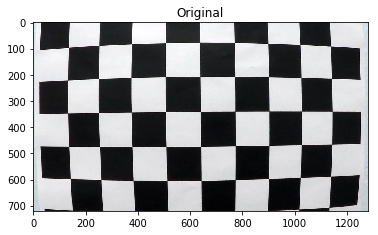

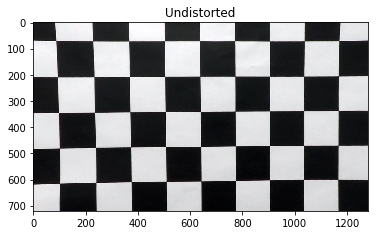

In [4]:
# Test calibration
image = cv2.imread('camera_cal/calibration1.jpg')
plt.figure(); plt.title('Original'); plt.imshow(image)
undist = undistort_image(image, camera_objpoints, camera_imgpoints)
plt.figure(); plt.title('Undistorted'); plt.imshow(undist)


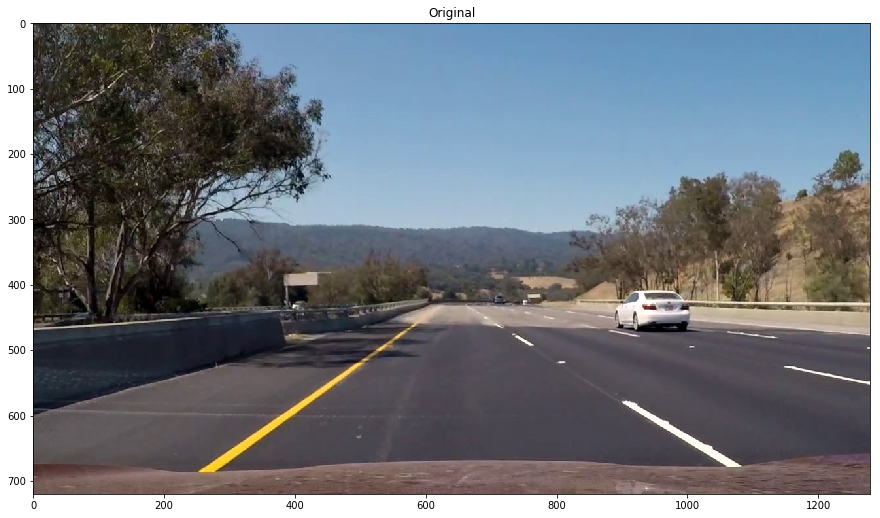

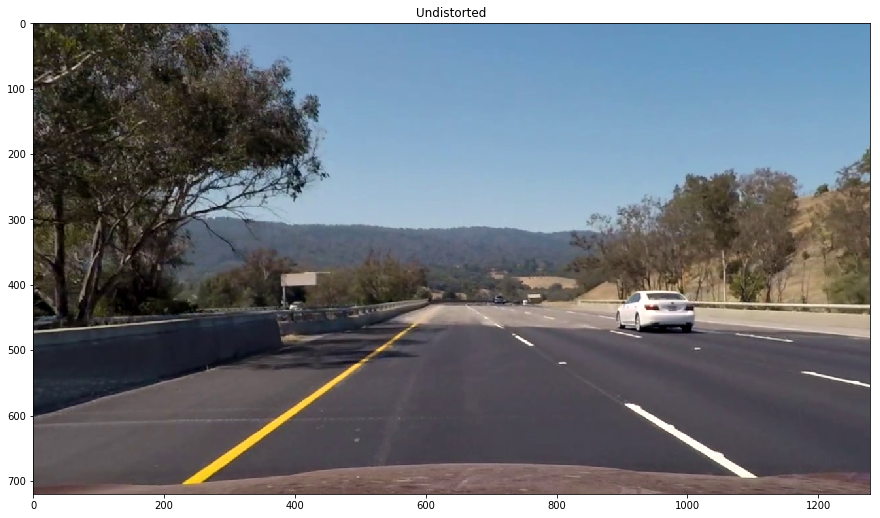

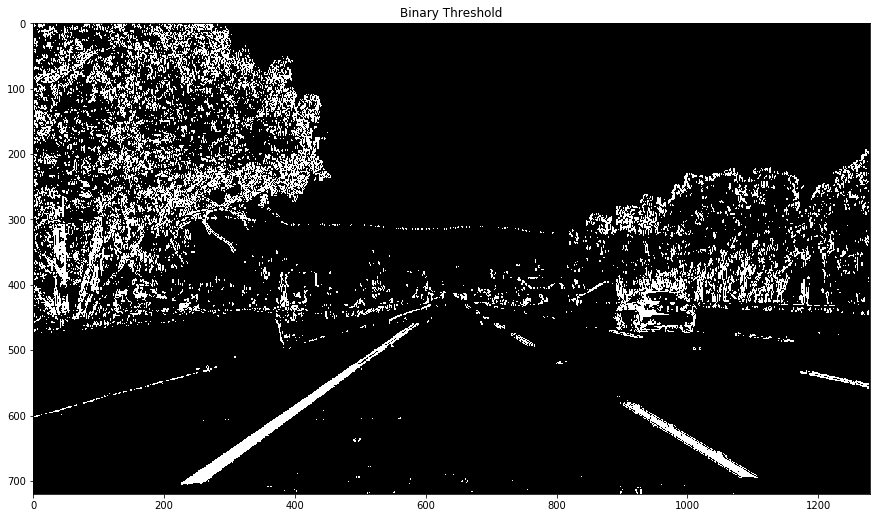

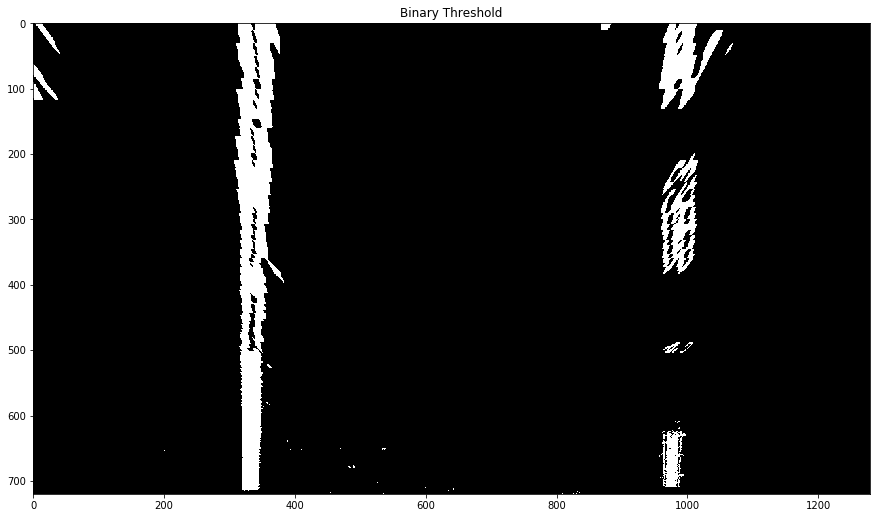

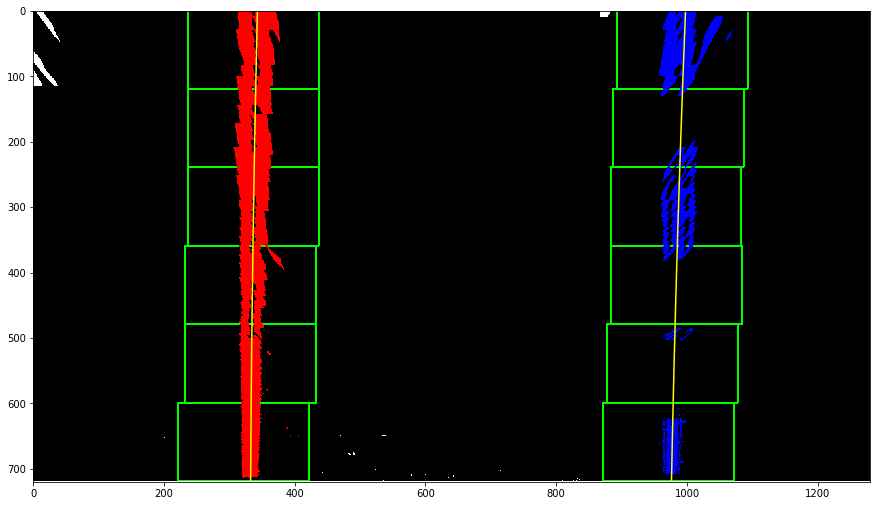

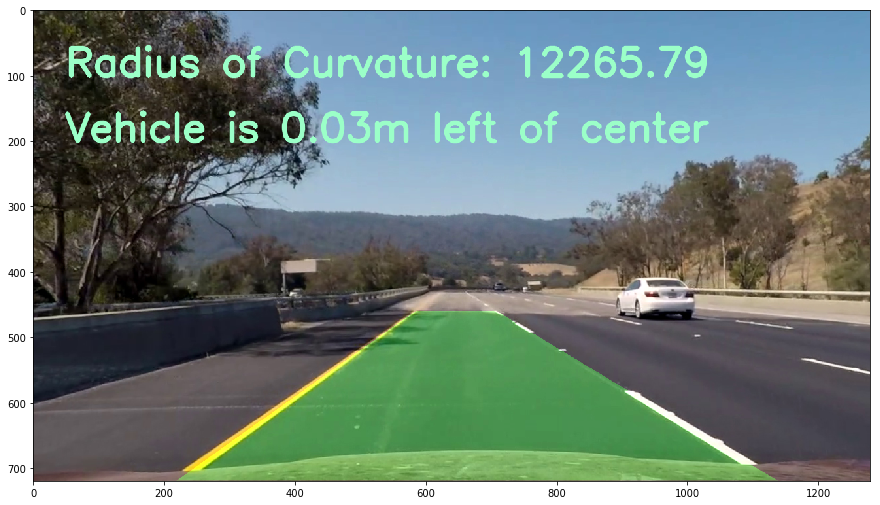

In [5]:
# Undistort image
#orig_image = cv2.imread('/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
#plt.figure(); plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
#undistorted_image = undistort_image(orig_image, camera_objpoints, camera_imgpoints)

#orig_image = cv2.imread('/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg')
orig_image = cv2.imread('/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Advanced-Lane-Lines/test_images/challenge3.jpg')
plt.figure(figsize=(15,15)); plt.title('Original'); plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
undistorted_image = undistort_image(orig_image, camera_objpoints, camera_imgpoints)
plt.figure(figsize=(15,15)); plt.title('Undistorted'); plt.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
binary_thresh_image = color_threshold(undistorted_image)
plt.figure(figsize=(15,15)); plt.title('Binary Threshold'); plt.imshow(binary_thresh_image, cmap='gray')
binary_warped_image, Minv = transform_perspective(binary_thresh_image)
plt.figure(figsize=(15,15)); plt.title('Binary Threshold'); plt.imshow(binary_warped_image, cmap='gray')
left_fit, right_fit = fit_lane_lines(binary_warped_image)
left_rad, right_rad = get_radius_curvature(binary_warped_image, left_fit, right_fit)
inv_persp_image = transform_inv_perspective(undistorted_image, binary_warped_image, left_fit, right_fit, Minv)
dist_off_center_str = get_off_center_distance(binary_warped_image)
final_image = add_data_to_image(inv_persp_image, dist_off_center_str, left_rad, right_rad)
plt.figure(figsize=(15,15)); plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))

In [6]:
#left_fit_previous3 = left_fit
#right_fit_previous3 = right_fit

def create_contour(binary_warped, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    return color_warp

def approximate_new_fit(binary_warped_image, left_fit_previous, right_fit_previous, left_fit_next, right_fit_next, gamma):
    color_warp_prev = create_contour(binary_warped_image, left_fit_previous, right_fit_previous)
    color_warp_next = create_contour(binary_warped_image, left_fit_next, right_fit_next)
    warp_prev = cv2.cvtColor(color_warp_prev, cv2.COLOR_RGB2GRAY)
    warp_next = cv2.cvtColor(color_warp_next, cv2.COLOR_RGB2GRAY)
    #plt.figure(); plt.imshow(warp_prev, cmap='gray')
    #plt.figure(); plt.imshow(warp_next, cmap='gray')
    ret = cv2.matchShapes(warp_prev,warp_next,1,0.0)
    #print(ret)
    if (ret > 0.0002):
        left_fit_next = gamma*left_fit_previous + (1-gamma)*left_fit_next
        right_fit_next = gamma*right_fit_previous + (1-gamma)*right_fit_next
    else:
        left_fit_next = 0.5*left_fit_previous + 0.5*left_fit_next
        right_fit_next = 0.5*right_fit_previous + 0.5*right_fit_next
    #color_warp_next = create_contour(binary_warped_image, left_fit_next, right_fit_next)
    #warp_next = cv2.cvtColor(color_warp_next, cv2.COLOR_RGB2GRAY)
    #plt.figure(); plt.imshow(warp_next, cmap='gray')
    #ret = cv2.matchShapes(warp_prev,warp_next,1,0.0)
    #print(ret)
    return left_fit_next, right_fit_next

#approximate_new_fit(binary_warped_image, left_fit_previous, right_fit_previous, left_fit_previous3, right_fit_previous3, 0.8)



#plt.figure(); plt.imshow(binary_warped_image, cmap='gray')
#color_warp1 = create_contour(binary_warped_image, left_fit_previous, right_fit_previous)
#plt.figure(); plt.imshow(color_warp1)
#color_warp2 = create_contour(binary_warped_image, left_fit_previous2, right_fit_previous2)
#plt.figure(); plt.imshow(color_warp2)
#color_warp3 = create_contour(binary_warped_image, left_fit_previous3, right_fit_previous3)

#print(color_warp1.shape)
#color_warp1 = cv2.cvtColor(color_warp1, cv2.COLOR_RGB2GRAY)
#color_warp2 = cv2.cvtColor(color_warp2, cv2.COLOR_RGB2GRAY)
#color_warp3 = cv2.cvtColor(color_warp3, cv2.COLOR_RGB2GRAY)

#plt.figure(); plt.imshow(color_warp1, cmap='gray')
#plt.figure(); plt.imshow(color_warp2, cmap='gray')
#plt.figure(); plt.imshow(color_warp3, cmap='gray')


#ret = cv2.matchShapes(color_warp1,color_warp2,1,0.0)
#print(ret)
#ret = cv2.matchShapes(color_warp1,color_warp3,1,0.0)
#print(ret)
#ret = cv2.matchShapes(color_warp2,color_warp3,1,0.0)
#print(ret)
#ret, thresh1 = cv2.threshold(color_warp1, 127, 255,0)
#im2, contours, hierarchy = cv2.findContours(thresh1,2,1)


run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
import moviepy

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# Calibrate camera
camera_objpoints, camera_imgpoints = calibrate_camera()

In [12]:
def process_image(image):
    undistorted_image = undistort_image(image, camera_objpoints, camera_imgpoints)
    binary_thresh_image = color_threshold(undistorted_image)
    binary_warped_image, Minv = transform_perspective(binary_thresh_image)
    left_fit_next, right_fit_next = fit_lane_lines(binary_warped_image)
    left_rad, right_rad = get_radius_curvature(binary_warped_image, left_fit_next, right_fit_next)
    inv_persp_image = transform_inv_perspective(undistorted_image, binary_warped_image, left_fit_next, right_fit_next, Minv)
    dist_off_center_str = get_off_center_distance(binary_warped_image)
    final_image = add_data_to_image(inv_persp_image, dist_off_center_str, left_rad, right_rad)
    #print(final_image.shape)
    return final_image

first_fit = 0
left_fit_previous = np.zeros(3)
right_fit_previous = np.zeros(3)
left_fit_next = np.zeros(3)
right_fit_next = np.zeros(3)

def process_image_new(image):
    global first_fit, left_fit_previous, right_fit_previous
    global left_fit_next, right_fit_next
    undistorted_image = undistort_image(image, camera_objpoints, camera_imgpoints)
    binary_thresh_image = color_threshold(undistorted_image)
    binary_warped_image, Minv = transform_perspective(binary_thresh_image)
    if (first_fit == 0):
        #print("left_fit_previous first: ", left_fit_previous)
        #print("right_fit_previous first: ", right_fit_previous)
        left_fit_next, right_fit_next = fit_lane_lines(binary_warped_image)
        first_fit = 1
        left_fit_previous = left_fit_next
        right_fit_previous = right_fit_next
    else:
        #print("left_fit_previous: ", left_fit_previous)
        #print("right_fit_previous: ", right_fit_previous)
        left_fit_next, right_fit_next = fit_new_lane_lines(binary_warped_image, left_fit_previous, right_fit_previous)
        left_fit_next, right_fit_next = approximate_new_fit(binary_warped_image, left_fit_previous, right_fit_previous, left_fit_next, right_fit_next, 0.9)
        left_fit_previous = left_fit_next
        right_fit_previous = right_fit_next
    #print("left_fit_next: ", left_fit_next)
    #print("right_fit_next: ", right_fit_next)
    left_rad, right_rad = get_radius_curvature(binary_warped_image, left_fit_next, right_fit_next)
    inv_persp_image = transform_inv_perspective(undistorted_image, binary_warped_image, left_fit_next, right_fit_next, Minv)
    dist_off_center_str = get_off_center_distance(binary_warped_image)
    final_image = add_data_to_image(inv_persp_image, dist_off_center_str, left_rad, right_rad)
    #print(final_image.shape)
    return final_image

Let's try the one with the solid white lane on the right first ...

In [10]:
moviepy.__version__

'0.2.2.13'

In [14]:
last_frame_left = None
last_frame_right = None

white_output = '/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Advanced-Lane-Lines/challenge_video_output.mp4'
clip1 = VideoFileClip("/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Advanced-Lane-Lines/challenge_video.mp4")
#print(clip1.get_frame(0).shape)
white_clip = clip1.fl_image(process_image_new) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

<class 'moviepy.video.io.VideoFileClip.VideoFileClip'>
[MoviePy] >>>> Building video /Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Advanced-Lane-Lines/challenge_video_output.mp4
[MoviePy] Writing video /Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Advanced-Lane-Lines/challenge_video_output.mp4


100%|██████████| 485/485 [05:40<00:00,  1.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Advanced-Lane-Lines/challenge_video_output.mp4 

CPU times: user 6min, sys: 18.3 s, total: 6min 19s
Wall time: 5min 40s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:13<00:00, 51.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12.3 s, sys: 2.71 s, total: 15 s
Wall time: 13.7 s


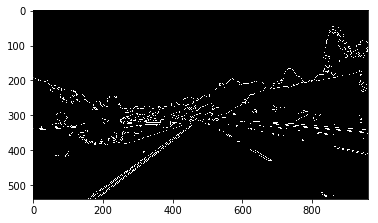

In [35]:
last_frame_left = None
last_frame_right = None

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


Lane Detection Pipeline:
- First I converted the image to grayscale and added Gaussian blur to the image.
- Then I found edges in the image, by using canny edge detection. Worked trying out few min/max parameters for canny and found 50/150 to be a good choice.
- Since we are interested in only the lanes, we need to filter our that particular region by masking out the image. So I masked out only the lanes.
- After masking, I calucated Hough transform of the image to find out long continuous lines of the lanes and ignore all other lines in the image.
- Until here we have the lines of lanes that we are interested, so finally just merge these lines with the original image by adding both together with appropriate weights.
- Finally save the image.

For images, it was challenging to save the image using cv2 because the default image color depth was BGR and cv2.write expects RGB while saving, so I had to figure out a way to do that and finally use below code:

cv2.imwrite(new_file, cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))

For videos however I did not have to do this conversion and BGR color depth worked fine.

Future work:
I think right now in video mode, the lane lines detected flicker between the frames. I can enhance this to ignore small changes in the lines to avoid flickering.
For optional challenge, first obstacle was getting the masked region right, so I had to calculate coordinates of the region relative to the image size. The second obstable I am facing right now is during calculating Hough Transform. I need to ignore the horizontal lines and consider only the slant ones, I will try working on it but meanwhile would want to go ahead and submit this project.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:13<00:00, 19.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 18.1 s, sys: 4.47 s, total: 22.6 s
Wall time: 14 s


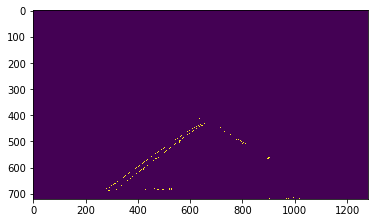

In [37]:
last_frame_left = None
last_frame_right = None

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image_new)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))